# LSTM
|      | LSTM |
|------|------------------|
| RMSE | 35316.32         |
| MAE  | 21944.25         |
| MAPE | 0.23             |

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Paired")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

# Constantes e funções

In [3]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [4]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [5]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [6]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()

In [7]:


def get_pred (y_train, y_pred):
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    pred['estados'] = SIGLAS * 30
    
    pred['y_test'] =  y_test[len(y_test) % 27 :].values
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    return pred

In [8]:
def show_pred (pred, states=SIGLAS):
    
    for state in states:
        
        fig, ax = plt.subplots()

        pred[pred['estados'] == state].plot(y="y_pred", ax=ax, figsize=(12,6), color="coral", title=f"Previsão x Dado Real: {state}", ylabel="Consumo")
        pred[pred['estados'] == state].plot(y="y_test", linestyle=' ', marker="o", ax=ax)

    plt.show()

In [9]:
def split_sequences(seq, size):
    
    lis = []
    
    for ini in range(len(seq)):
        
        end = ini + size
        
        if end > len(seq):
            break
            
            
        lis += [seq[ini:end]]
        
    return np.array(lis)

In [10]:
class Scaler3DShape:
    
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() 

    def fit_transform(self, x):
        x_new = self.scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

    def transform(self, x):
        x_new = self.scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

# SEED

In [11]:
SEED = 41

def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [12]:
STATES = ['SP', 'RS','AL','DF']

# Dados

In [14]:
def load_data():
    
    df = pd.read_csv(f"{PATH}processado.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

# Experimentos

## 1 camada LSTM (128) 

#### sem relu e 100 epochs

In [23]:
set_seeds(41)

x,y = load_data()

timestep=5

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestep)
x_test = split_sequences(x_test.values, timestep)
y_train = y_train[:-timestep+1]
y_test = y_test[:-timestep+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128)),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 266562.30824369815
MAE: 158602.99647015857
MAPE: 0.9503471486726411
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 230042.69356817077
MAE: 145363.86099321034
MAPE: 0.9564304894123259


#### com relu e 100 epochs

In [24]:
set_seeds(41)

x,y = load_data()

timestep=5

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestep)
x_test = split_sequences(x_test.values, timestep)
y_train = y_train[:-timestep+1]
y_test = y_test[:-timestep+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 29702.85585263158
MAE: 17178.75251616183
MAPE: 0.18278079851651766
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 36865.30999084915
MAE: 23611.740512036755
MAPE: 0.3129729833573097


## 1 camada LSTM (128) e 2 Dense (64 e 32)

#### 100 epochs e time=5

In [22]:
set_seeds()

x,y = load_data()

timestamp=5

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestamp)
x_test = split_sequences(x_test.values, timestamp)
y_train = y_train[:-timestamp+1]
y_test = y_test[:-timestamp+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128)),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 38929.62710779666
MAE: 22134.080596664262
MAPE: 0.2103375143543596


## 2 LSTM (128, 64) e 2 Dense (64 e 32)

#### time=3

In [27]:
set_seeds(41)

x,y = load_data()

timestep=3

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestep)
x_test = split_sequences(x_test.values, timestep)
y_train = y_train[:-timestep+1]
y_test = y_test[:-timestep+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(LSTM(units=64, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 28446.390410644275
MAE: 15645.668557339393
MAPE: 0.2055054801148388
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 36710.4823093514
MAE: 22973.494454900567
MAPE: 0.29400437699978854


##### tempo=5

In [28]:
set_seeds(41)

x,y = load_data()

timestep=5

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestep)
x_test = split_sequences(x_test.values, timestep)
y_train = y_train[:-timestep+1]
y_test = y_test[:-timestep+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(LSTM(units=64, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 7ms/step
Scores obtidos:
RMSE: 26171.674598480804
MAE: 14452.691103775633
MAPE: 0.1683764925728891
26/26 [==============================] - 0s 6ms/step
Scores obtidos:
RMSE: 35316.328513055894
MAE: 21944.253998210625
MAPE: 0.2362936403479378


In [15]:
set_seeds(41)

x,y = load_data()

timestep=5

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestep)
x_test = split_sequences(x_test.values, timestep)
y_train = y_train[:-timestep+1]
y_test = y_test[:-timestep+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(LSTM(units=64, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 5ms/step
Scores obtidos:
RMSE: 26171.674598480804
MAE: 14452.691103775633
MAPE: 0.1683764925728891
26/26 [==============================] - 0s 6ms/step
Scores obtidos:
RMSE: 35316.328513055894
MAE: 21944.253998210625
MAPE: 0.2362936403479378


In [19]:
set_seeds(41)

x,y = load_data()

timestep=5

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestep)
x_test = split_sequences(x_test.values, timestep)
y_train = y_train[:-timestep+1]
y_test = y_test[:-timestep+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, activation="relu")),
model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(LSTM(units=64, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 9ms/step
Scores obtidos:
RMSE: 28642.966748862633
MAE: 15814.332179722576
MAPE: 0.21224842183153125
26/26 [==============================] - 0s 9ms/step
Scores obtidos:
RMSE: 35628.175519535995
MAE: 22673.10295792831
MAPE: 0.29926828974202263


In [20]:
set_seeds(41)

x,y = load_data()

timestep=5

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestep)
x_test = split_sequences(x_test.values, timestep)
y_train = y_train[:-timestep+1]
y_test = y_test[:-timestep+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(LSTM(units=64, activation="relu")),
model.add(Dense(units=64))
model.add(Dense(units=32))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 24702.26887925225
MAE: 13739.745965291837
MAPE: 0.15999445002800225
26/26 [==============================] - 0s 5ms/step
Scores obtidos:
RMSE: 34621.51869485885
MAE: 21088.461669625227
MAPE: 0.23828570973079136


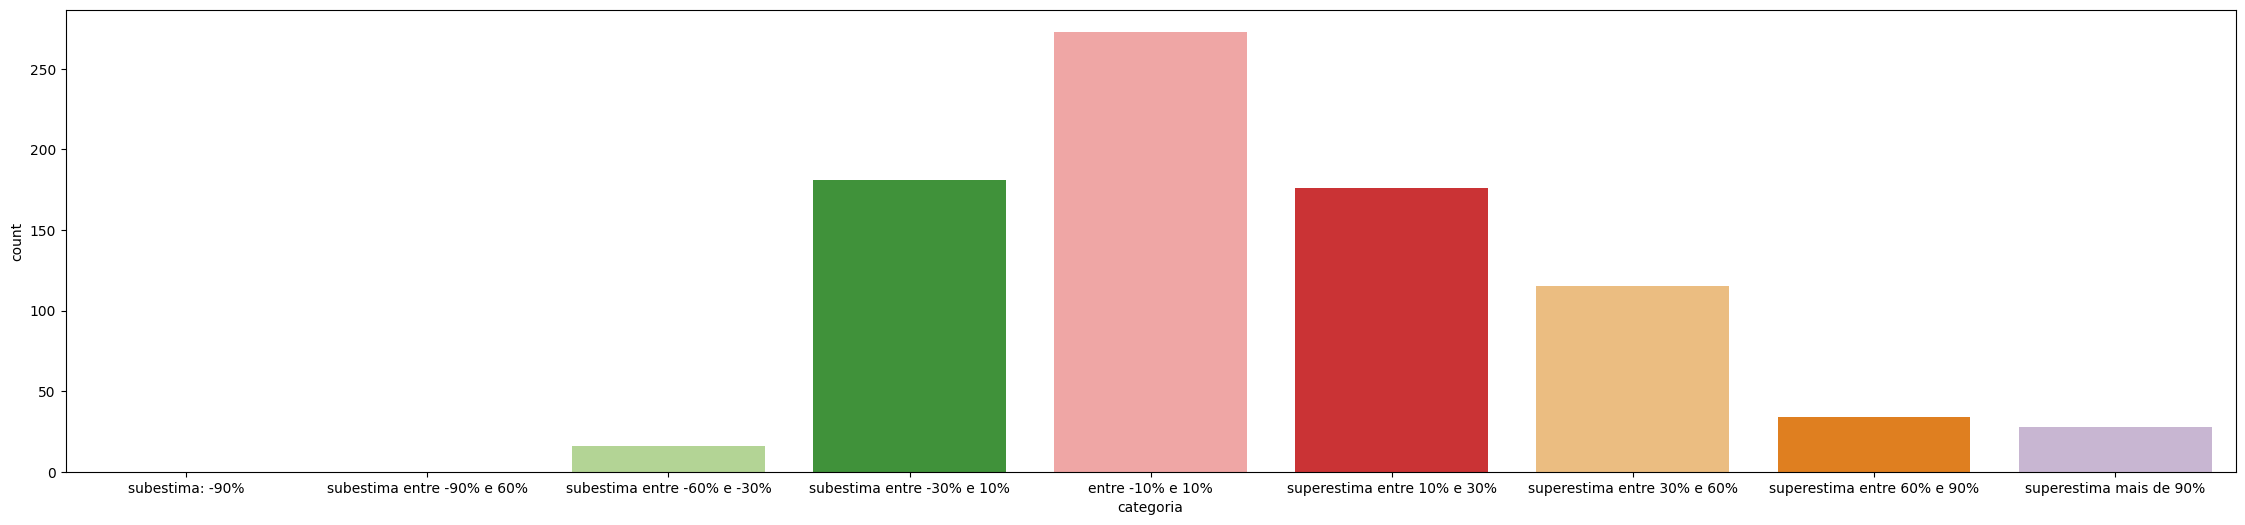

In [21]:
show_delta(np.array(y_test), y_pred.flatten())

In [22]:
def show_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
    
    
    plt.title("Visão regional")
    
    for state in reg:
        
        sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
        sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.ylabel="Consumo"
        
    plt.show()

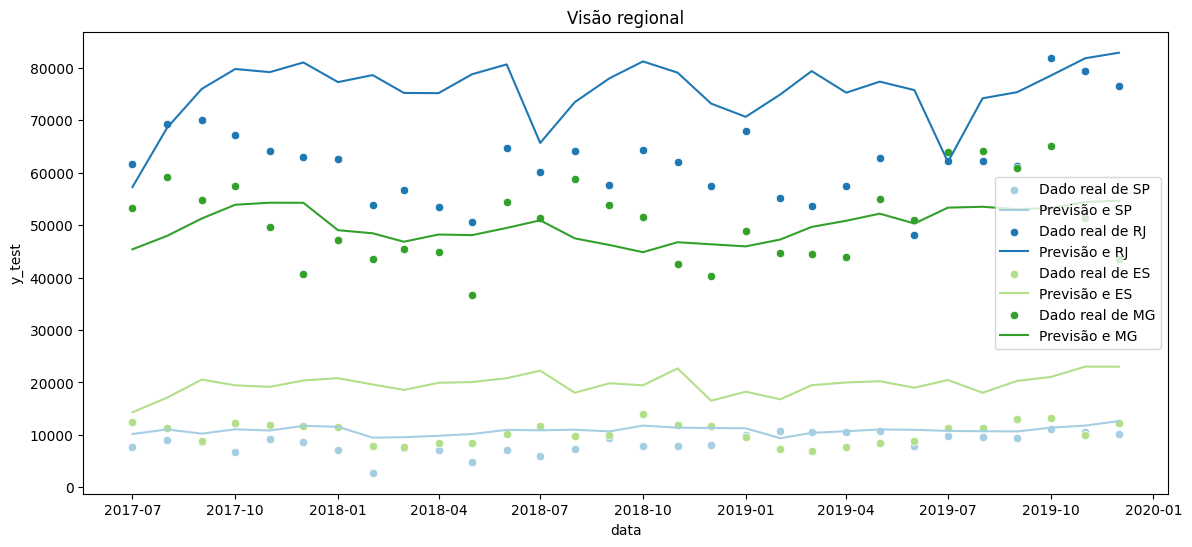

In [23]:
pred = get_pred(y_test, y_pred)

SUDESTE = ['SP', 'RJ', 'ES', 'MG']

show_graphs(pred, SUDESTE)

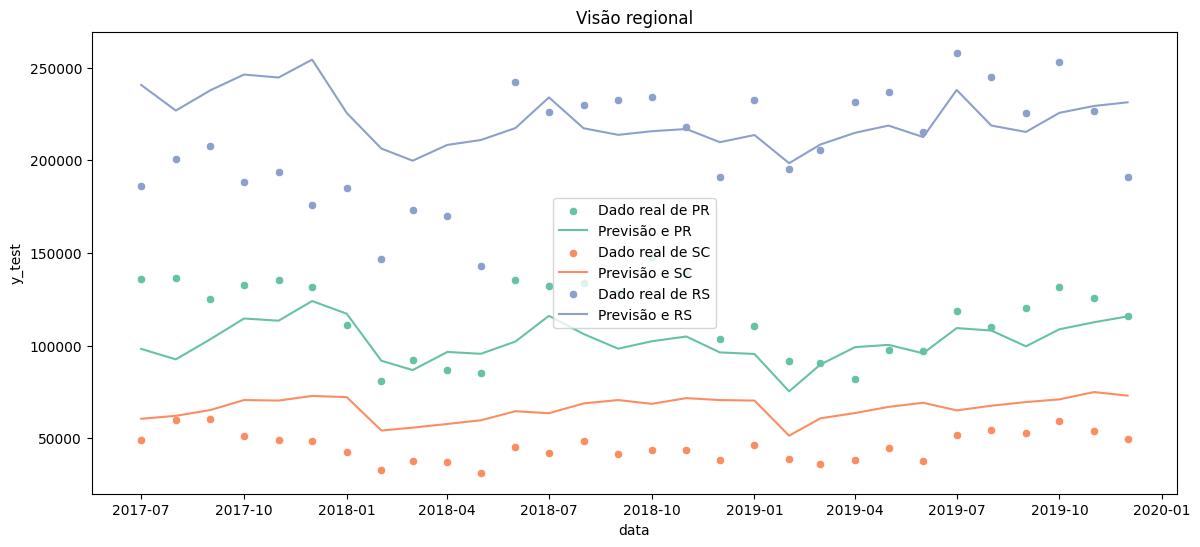

In [24]:
SUL = ['PR', 'SC', 'RS']

sns.set_palette("Set2")

show_graphs(pred, SUL)